In [1]:
pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 12.3 MB/s eta 0:00:00


In [2]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
num_init_train_samples = 20
num_pool_samples = 5
num_test_samples = 20

input_dim = 1

In [4]:
init_train_x = torch.rand((num_init_train_samples, input_dim))*50.0

test_x_1 = torch.rand((num_test_samples, input_dim))*50.0

test_x_2 = 75.0 + torch.rand((num_test_samples, input_dim))*50.0

test_x_3 = 175.0 + torch.rand((num_test_samples, input_dim))*50.0

test_x = torch.cat([test_x_1,test_x_2,test_x_3])

pool_x_1 = 24 + torch.rand((num_pool_samples, input_dim))*2

pool_x_2 = 99 + torch.rand((num_pool_samples, input_dim))*2

pool_x_3 = 199 + torch.rand((num_pool_samples, input_dim))*2

pool_x = torch.cat([pool_x_1,pool_x_2,pool_x_3])


y = torch.zeros(num_init_train_samples+3*num_pool_samples+3*num_test_samples)

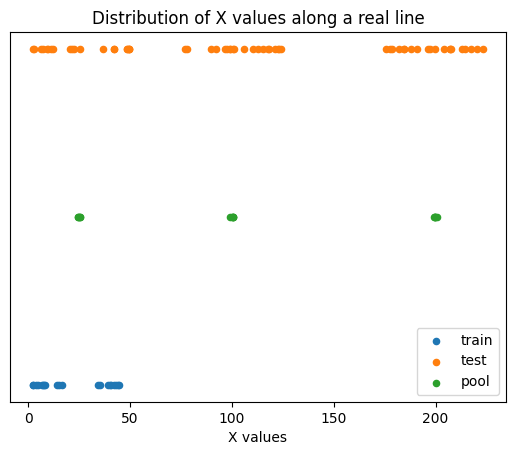

In [5]:
init_train_x_numpy = init_train_x.numpy()
init_train_y = torch.zeros(init_train_x.size(0))
test_x_numpy = test_x.numpy()
test_y = torch.ones(test_x.size(0))
pool_x_numpy = pool_x.numpy()
pool_y = torch.empty(pool_x.size(0)).fill_(0.5)


plt.scatter(init_train_x_numpy, init_train_y.numpy(), s=20, label='train')
plt.scatter(test_x_numpy, test_y.numpy(), s=20, label='test')
plt.scatter(pool_x_numpy, pool_y.numpy(), s=20, label='pool')

plt.yticks([])  # Hide y-axis ticks
plt.xlabel('X values')
plt.legend()
plt.title('Distribution of X values along a real line')
plt.show()

In [6]:
x = torch.cat([init_train_x,test_x,pool_x])

In [7]:
# Define parameters for the model
mean_constant = 0.0  # Mean of the GP
length_scale = 25.0   # Length scale of the RBF kernel
noise_std = 0.01     # Standard deviation of the noise


mean_module = gpytorch.means.ConstantMean()
base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()


mean_module.constant = mean_constant
base_kernel.base_kernel.lengthscale = length_scale
likelihood.noise_covar.noise = noise_std**2

In [8]:
class CustomizableGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, mean_module, base_kernel, likelihood):
        super(CustomizableGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = base_kernel
        self.likelihood = likelihood

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean_module(x), self.covar_module(x))


model = CustomizableGPModel(x, y, mean_module, base_kernel, likelihood)

In [9]:
# Sample from the prior for training data
model.eval()
likelihood.eval()
with torch.no_grad():
    prior_dist = likelihood(model(x))
    y_new = prior_dist.sample()

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


(-0.1, 0.1)

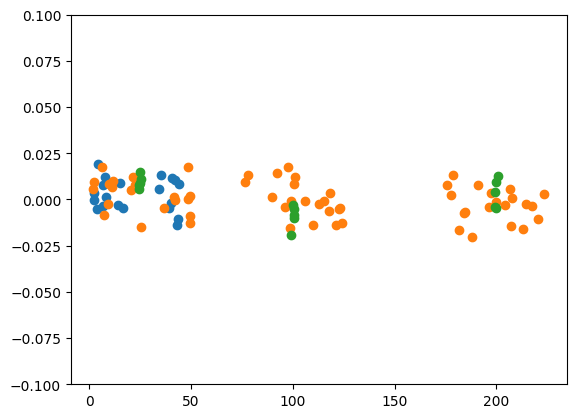

In [10]:
plt.scatter(x[:num_init_train_samples],y_new[:num_init_train_samples], label='train')
plt.scatter(x[num_init_train_samples:num_init_train_samples+3*num_test_samples],y_new[num_init_train_samples:num_init_train_samples+3*num_test_samples], label='test')
plt.scatter(x[num_init_train_samples+3*num_test_samples:],y_new[num_init_train_samples+3*num_test_samples:], label='pool')
plt.ylim(-0.1, 0.1)

In [11]:
class ConstantValueNetwork(nn.Module):
    def __init__(self, constant_value=1.0, output_size=1):
        super(ConstantValueNetwork, self).__init__()
        # Define the constant value and output size
        self.constant_value = nn.Parameter(torch.tensor([constant_value]*output_size), requires_grad=False)
        self.output_size = output_size

    def forward(self, x):
        # x is your input tensor. Its value is ignored in this model.
        # Return a 1-D tensor with the constant value for each item in the batch.
        batch_size = x.size(0)  # Get the batch size from the input
        return self.constant_value.expand(batch_size, self.output_size)

First of all what we want to calculate -

$$ {\mathbf Var}_{f \sim GP(\eta) } {\mathbf E}_{\epsilon} {\mathbf E}_{x} (f(x)+\epsilon(x) - p(x))^2 $$

Assuming homoscedastic noise

$$ {\mathbf Var}_{f \sim GP(\eta) } {\mathbf E}_{\epsilon} {\mathbf E}_{x} (f(x)+\epsilon - p(x))^2 $$

$$ {\mathbf Var}_{f \sim GP(\eta) } {\mathbf E}_{\epsilon} {\mathbf E}_{x} (f(x)- p(x))^2 + (\epsilon)^2 + 2\epsilon(f(x)- p(x))  $$

$$ {\mathbf Var}_{f \sim GP(\eta) } \left[{\mathbf E}_{\epsilon} {\mathbf E}_{x} (f(x)- p(x))^2 + {\mathbf E}_{\epsilon} {\mathbf E}_{x} (\epsilon)^2 + {\mathbf E}_{\epsilon} {\mathbf E}_{x} 2\epsilon(f(x)- p(x)) \right] $$

$$ {\mathbf Var}_{f \sim GP(\eta) } \left[{\mathbf E}_{x} (f(x)- p(x))^2 + \sigma^2 + 2({\mathbf E}_{\epsilon}\epsilon)( {\mathbf E}_{x} (f(x)- p(x))) \right] $$

$$ {\mathbf Var}_{f \sim GP(\eta) } \left[ {\mathbf E}_{x} (f(x)- p(x))^2 + \sigma^2 \right] $$

$$ {\mathbf Var}_{f \sim GP(\eta) } \left[ {\mathbf E}_{x} (f(x)- p(x))^2 \right] $$




$${\mathbf E}_{\epsilon} {\mathbf E}_{x} (f(x)+\epsilon(x) - p(x))^2 =^{?}  {\mathbf E}_{x} {\mathbf E}_{\epsilon} (f(x)+\epsilon(x) - p(x))^2$$

### **Be careful above is not the case in RECALL**

$$ {\mathbf Var}_{f \sim GP(\eta) } {\mathbf E}_{\epsilon} {\mathbf E}_{x} [{\mathbf 1}(p(x)>0)|g(f(x),\epsilon(x))=1] $$

$${\mathbf E}_{\epsilon} {\mathbf E}_{x} [{\mathbf 1}(p(x)>0)|g(f(x),\epsilon(x))=1] =^{?} {\mathbf E}_{x}{\mathbf E}_{\epsilon} [{\mathbf 1}(p(x)>0)|g(f(x),\epsilon(x))=1]$$

$$ {\mathbf Var}_{f \sim GP(\eta) } {\mathbf E}_{\epsilon} \frac{ {\mathbf E}_{x} [{\mathbf 1}(p(x)>0) g(f(x),\epsilon)]}{ {\mathbf E}_{x} [ g(f(x),\epsilon)]} $$




In [12]:
### Adapting L_2 loss for the GP pipeine

def var_l2_loss_estimator(model, test_x, Predictor, device, para):
    #z_dim = para['z_dim']

    #N_iter =  para['N_iter']
    #if_print =  para['if_print']
    #seed = para['seed_var_l2']
    #torch.manual_seed(seed)

    N_iter =  100
    seed = 0
    torch.manual_seed(seed)

    #res  = torch.empty((0), dtype=torch.float32, device=device)
    #res_square  = torch.empty((0), dtype=torch.float32, device=device)



    latent_posterior = model(test_x)
    latent_posterior_sample = latent_posterior.rsample(sample_shape=torch.Size([N_iter]))
    #print("latent_posterior_sample:", latent_posterior_sample)
    #print("latent_posterior_sample.shape:", latent_posterior_sample.shape)
    prediction = Predictor(test_x).squeeze()
    #print("prediction:", prediction)
    L_2_loss_each_point = torch.square(torch.subtract(latent_posterior_sample, prediction))
    #print("L_2_loss_each_point:", L_2_loss_each_point)
    L_2_loss_each_f = torch.mean(L_2_loss_each_point, dim=1)
    #print("L_2_loss_each_f_size:", L_2_loss_each_f.shape)
    #print("L_2_loss_each_f:",L_2_loss_each_f)
    L_2_loss_variance = torch.var(L_2_loss_each_f)
    print("L_2_loss_variance:",L_2_loss_variance)

    L_2_loss_mean = torch.mean(L_2_loss_each_f)+model.likelihood.noise
    print("L_2_loss_mean:", L_2_loss_mean)

    return L_2_loss_variance



In [13]:
def l2_loss(test_x, test_y, Predictor, device):
    prediction = Predictor(test_x).squeeze()
    #print("prediction:", prediction)
    #print("test_y:", test_y)
    diff_square = torch.square(torch.subtract(test_y, prediction))
    #print("diff_square:", diff_square)
    return torch.mean(diff_square)

In [14]:
Predictor = ConstantValueNetwork(constant_value=0.0, output_size=1)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


L_2_loss_variance: tensor(0.1119, grad_fn=<VarBackward0>)
L_2_loss_mean: tensor([0.3973], grad_fn=<AddBackward0>)
l_2_loss_actual: tensor(9.1129e-05)


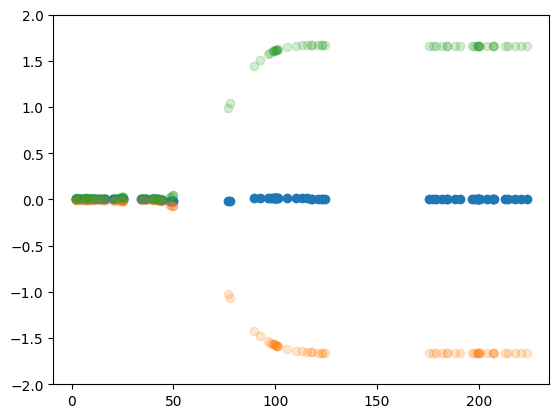

In [15]:
model.set_train_data(inputs=x[:num_init_train_samples], targets=y_new[:num_init_train_samples], strict=False)       ####### CAN ALSO USE TRAINING OVER NLL HERE########

### IMP LINK - https://github.com/cornellius-gp/gpytorch/issues/1409
### IMP LINK - https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
posterior = (model(x))
posterior_mean = posterior.mean
posterior_var = posterior.variance
#print("posterior_var:",posterior_var)


plt.scatter(x,posterior_mean.detach().numpy())
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()-2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()+2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)

var_l2_loss_estimator(model, test_x, Predictor, None, None)

l_2_loss_actual = l2_loss(test_x, y_new[num_init_train_samples:num_init_train_samples+3*num_test_samples], Predictor, None)
print("l_2_loss_actual:", l_2_loss_actual)

L_2_loss_variance: tensor(0.0435, grad_fn=<VarBackward0>)
L_2_loss_mean: tensor([0.2059], grad_fn=<AddBackward0>)


tensor(0.0435, grad_fn=<VarBackward0>)

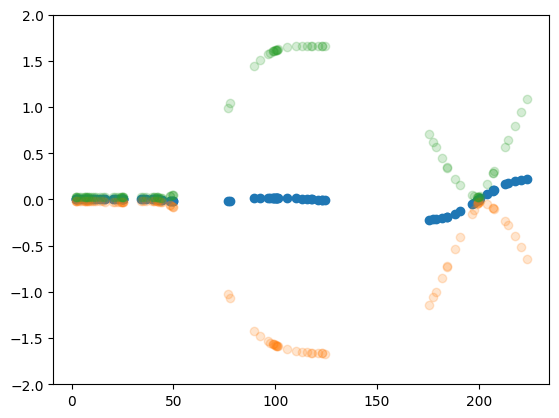

In [16]:
new_train_x = torch.cat([x[:num_init_train_samples],x[-2:]])
new_train_y = torch.cat([y_new[:num_init_train_samples],y_new[-2:]])

model.set_train_data(inputs=new_train_x, targets=new_train_y, strict=False)       ####### CAN ALSO USE TRAINING OVER NLL HERE########

posterior = likelihood(model(x))
posterior_mean = posterior.mean
posterior_var = posterior.variance


plt.scatter(x,posterior_mean.detach().numpy())
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()-2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()+2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)
var_l2_loss_estimator(model, test_x, Predictor, None, None)

L_2_loss_variance: tensor(0.0047, grad_fn=<VarBackward0>)
L_2_loss_mean: tensor([0.0635], grad_fn=<AddBackward0>)


tensor(0.0047, grad_fn=<VarBackward0>)

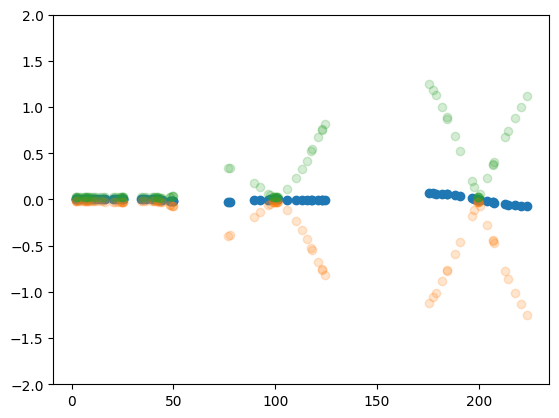

In [17]:
new_train_x = torch.cat([x[:num_init_train_samples],x[num_init_train_samples+num_test_samples*3+num_pool_samples+1:num_init_train_samples+num_test_samples*3+num_pool_samples*2+2],x[-1:]])
new_train_y = torch.cat([y_new[:num_init_train_samples],y[num_init_train_samples+num_test_samples*3+num_pool_samples+1:num_init_train_samples+num_test_samples*3+num_pool_samples*2+2],y_new[-1:]])

model.set_train_data(inputs=new_train_x, targets=new_train_y, strict=False)       ####### CAN ALSO USE TRAINING OVER NLL HERE########

posterior = likelihood(model(x))
posterior_mean = posterior.mean
posterior_var = posterior.variance


plt.scatter(x,posterior_mean.detach().numpy())
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()-2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()+2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)
var_l2_loss_estimator(model, test_x, Predictor, None, None)

In [18]:
class GaussianProcessCholesky(nn.Module):
    def __init__(self, kernel):
        super(GaussianProcessCholesky, self).__init__()
        self.kernel = kernel

    def forward(self, x_train, y_train, w_train, x_test, noise=1e-4):

        # Apply weights only to non-diagonal elements

        K = self.kernel(x_train, x_train) + noise * torch.eye(x_train.size(0)) + 1e-6 * torch.eye(x_train.size(0))
        non_diag_mask = 1 - torch.eye(K.size(-2), K.size(-1))
        weight_matrix = w_train.unsqueeze(-1) * w_train.unsqueeze(-2)
        weighted_K =  K * (non_diag_mask * weight_matrix + (1 - non_diag_mask))



        K_s = self.kernel(x_train, x_test)
        weighted_K_s = torch.diag(w_train)@K_s

        K_ss = self.kernel(x_test, x_test) + 1e-6 * torch.eye(x_test.size(0))

        L = torch.linalg.cholesky(weighted_K)
        alpha = torch.cholesky_solve(y_train.unsqueeze(1), L)
        mu = weighted_K_s.t().matmul(alpha).squeeze(-1)

        v = torch.linalg.solve(L, weighted_K_s)
        cov = K_ss - v.t().matmul(v)

        return mu, cov


In [19]:
class RBFKernel(nn.Module):
    def __init__(self, length_scale= 0.6931471824645996, output_scale = 0.6931471824645996):
        super(RBFKernel, self).__init__()
        self.length_scale = length_scale
        self.output_scale = output_scale
    def forward(self, x1, x2):
        dist_matrix = torch.cdist(x1.unsqueeze(0), x2.unsqueeze(0), p=2).squeeze(0)**2
        return self.output_scale*torch.exp(-0.5 * dist_matrix / self.length_scale**2)


In [43]:
import torch

def sample_multivariate_normal(mu, cov, n_samples):
    """
    Sample from a multivariate normal distribution using the reparameterization trick.

    Parameters:
    - mu (torch.Tensor): The mean vector of the distribution.    1-D dimension [D]
    - cov (torch.Tensor): The covariance matrix of the distribution.  2-D dimension [D,D]
    - n_samples (int): The number of samples to generate.

    Returns:
    - torch.Tensor: Samples from the multivariate normal distribution.
    """
    # Ensure mu and cov are tensors
    #mu = torch.tensor(mu, dtype=torch.float32)
    #cov = torch.tensor(cov, dtype=torch.float32)

    # Cholesky decomposition of the covariance matrix
    L = torch.linalg.cholesky(cov + 1e-5 * torch.eye(cov.size(0)))

    #L = torch.linalg.cholesky(cov + 1e-8 * torch.eye(cov.size(0)))

    # Sample Z from a standard normal distribution
    Z = torch.randn(n_samples, mu.size(0))           # Z: [n_samples, D]

    # Transform Z to obtain samples from the target distribution
    samples = mu + Z @ L.T

    return samples    #[n_samples, D]




In [44]:
### Adapting L_2 loss for the GP pipeine

def var_l2_loss_custom_gp_estimator(mu, cov, noise, test_x, Predictor, device, para):


    N_iter =  100
    seed = 0
    torch.manual_seed(seed)

    latent_posterior_sample = sample_multivariate_normal(mu, cov, N_iter)
    prediction = Predictor(test_x).squeeze()
    L_2_loss_each_point = torch.square(torch.subtract(latent_posterior_sample, prediction))
    L_2_loss_each_f = torch.mean(L_2_loss_each_point, dim=1)
    L_2_loss_variance = torch.var(L_2_loss_each_f)
    print("L_2_loss_variance:",L_2_loss_variance)

    L_2_loss_mean = torch.mean(L_2_loss_each_f)+noise
    print("L_2_loss_mean:", L_2_loss_mean)

    return L_2_loss_variance



In [45]:
def l2_loss(test_x, test_y, Predictor, device):
    prediction = Predictor(test_x).squeeze()
    #print("prediction:", prediction)
    #print("test_y:", test_y)
    diff_square = torch.square(torch.subtract(test_y, prediction))
    #print("diff_square:", diff_square)
    return torch.mean(diff_square)

L_2_loss_variance: tensor(0.0975)
L_2_loss_mean: tensor(0.3899)


<ipython-input-20-5fedde6c9e39>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mu, dtype=torch.float32)
<ipython-input-20-5fedde6c9e39>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov = torch.tensor(cov, dtype=torch.float32)


(-2.0, 2.0)

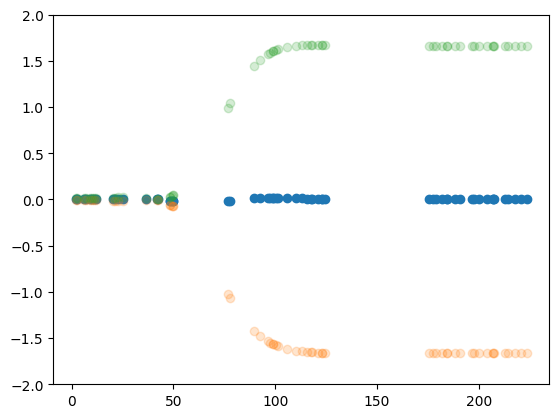

In [23]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
x_pool_2 = x[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
y_pool_2 = y_new[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]


x_gp = torch.cat([x_train,x_pool_1,x_pool_2], dim=0)
y_gp = torch.cat([y_train,y_pool_1,y_pool_2], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_pool_2 = torch.zeros(x_pool_2.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1,w_pool_2])



kernel = RBFKernel(length_scale=25.0, output_scale = 0.6931471824645996)
gp = GaussianProcessCholesky(kernel=kernel)
noise = 1e-4
# Prediction
mu2, cov2 = gp(x_gp, y_gp, w_gp, test_x, noise)

var_l2_loss_custom_gp_estimator(mu2, cov2, 1e-4, test_x, Predictor, None, None)

plt.scatter(test_x,mu2.detach().numpy())
plt.scatter(test_x.squeeze(),mu2.detach().numpy()-2*torch.sqrt(torch.diag(cov2)).detach().numpy(),alpha=0.2)
plt.scatter(test_x.squeeze(),mu2.detach().numpy()+2*torch.sqrt(torch.diag(cov2)).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)

L_2_loss_variance: tensor(0.0485, grad_fn=<VarBackward0>)
L_2_loss_mean: tensor(0.2137, grad_fn=<AddBackward0>)


(-2.0, 2.0)

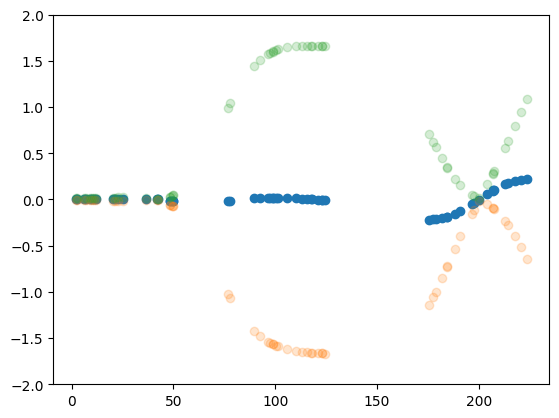

In [46]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
x_pool_2 = x[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
y_pool_2 = y_new[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]


x_gp = torch.cat([x_train,x_pool_1,x_pool_2], dim=0)
y_gp = torch.cat([y_train,y_pool_1,y_pool_2], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_pool_2 = torch.ones(x_pool_2.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1,w_pool_2])



kernel = RBFKernel(length_scale=25.0)
gp = GaussianProcessCholesky(kernel=kernel)

# Prediction
mu, cov = gp(x_gp, y_gp, w_gp, test_x)

var_loss = var_l2_loss_custom_gp_estimator(mu, cov, 1e-4, test_x, Predictor, None, None)

var_loss.backward()

plt.scatter(test_x,mu.detach().numpy())
plt.scatter(test_x.squeeze(),mu.detach().numpy()-2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.scatter(test_x.squeeze(),mu.detach().numpy()+2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)

In [77]:
z = torch.randn(mu.size(0))
L = torch.linalg.cholesky(cov + 1e-5 * torch.eye(cov.size(0)))  # Adding a small value for numerical stability
samples = mu + L.matmul(z)

In [47]:
import argparse
import typing

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributions as distributions
import numpy as np
from dataclasses import dataclass
import time
from datetime import datetime
import matplotlib.pyplot as plt

In [48]:
# Define a configuration class for dataset-related parameters
@dataclass
class DatasetConfig:
    csv_file_train: str
    csv_file_test: str
    csv_file_pool: str
    y_column: str  # Assuming same column name across above 3 sets


@dataclass
class ModelConfig:
    batch_size_query: int
    temp_k_subset: float
    hidden_sizes_weight_NN: list
    meta_opt_lr: float
    meta_opt_weight_decay: float





@dataclass
class TrainConfig:
    n_train_iter: int
    N_iter: int



@dataclass
class GPConfig:
    length_scale: float
    noise: float
    mean_constant: float

In [96]:
import torch.nn as nn

class NN_feature_weights(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN_feature_weights, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Combine all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
import torch
from torch import Tensor
import numpy as np

EPSILON = np.finfo(np.float32).tiny

class SubsetOperator(torch.nn.Module):
    def __init__(self, k, device, tau=1.0, hard=False):            # k is the number of samples we want, tau is the temperature parameter, hard:denotes if we want hard or soft samples
        super(SubsetOperator, self).__init__()
        self.k = k
        self.hard = hard
        self.tau = tau
        self.device=device

    def forward(self, scores):                                # scores take in weights of each sample      # scores: Typical shape: [batch_size,n] or [batch_size,n,1]
        m = torch.distributions.gumbel.Gumbel(torch.zeros_like(scores), torch.ones_like(scores))
        g = m.sample()
        scores = scores + g

        # continuous top k  (we can later modify this to also output S_WRS, we will just need each onehot_approx to be stored seperately - then it will give k soft vectors)
        khot = torch.zeros_like(scores)
        onehot_approx = torch.zeros_like(scores)
        for i in range(self.k):
            khot_mask = torch.max(1.0 - onehot_approx, torch.tensor([EPSILON], device=self.device))            # we can autodiff through this, there is no issue .
            # khot_mask = torch.max(1.0 - onehot_approx, torch.tensor([EPSILON]).cuda())      #CHECK MIGHT NEED TO PUT DEVICE HERE,
            scores = scores + torch.log(khot_mask)
            onehot_approx = torch.nn.functional.softmax(scores / self.tau, dim=1)
            khot = khot + onehot_approx

        if self.hard:
            # will do straight through estimation if training
            khot_hard = torch.zeros_like(khot)
            val, ind = torch.topk(khot, self.k, dim=1)
            khot_hard = khot_hard.scatter_(1, ind, 1)
            res = khot_hard - khot.detach() + khot
        else:
            res = khot

        return res

In [88]:

init_train_y_new = y_new[:num_init_train_samples]

test_y_new = y_new[num_init_train_samples:num_init_train_samples+num_test_samples*3]

pool_y_new = y_new[num_init_train_samples+num_test_samples*3:]

In [89]:
import math

In [100]:
input_feature_size = init_train_x.size(1)
#NN_weights = NN_feature_weights(input_feature_size, model_config.hidden_sizes_weight_NN, 1).to(device)

tensor_size = pool_x.size(0) # This could be tensor.shape[0] for the first dimension size, for example

# Convert the size to a tensor and calculate the reciprocal
reciprocal_size_value =  math.log(1.0 / tensor_size)

# Now compute the logarithm of the reciprocal
NN_weights = torch.full([tensor_size], reciprocal_size_value, requires_grad=True)





meta_opt = optim.Adam([NN_weights], lr=model_config.meta_opt_lr, weight_decay=model_config.meta_opt_weight_decay)       # meta_opt is optimizer for parameters of NN_weights

    #seed for this
SubsetOperator = SubsetOperator(model_config.batch_size_query, device, model_config.temp_k_subset, False).to(device)



In [101]:
def train(init_train_x, init_train_y, pool_x, pool_y, test_x, test_y, device, train_config, gp_config, NN_weights, meta_opt, SubsetOperator, Predictor, if_print = True):
  meta_loss_list = []
  for i in range(train_config.n_train_iter):    # Should we do this multiple times or not
    start_time = time.time()

    meta_opt.zero_grad()

    #pool_weights = NN_weights(pool_x)   #pool_weights has shape [pool_size,1]
    #pool_weights_t = pool_weights.t()  #convert pool_weights to shape [1, pool_size]

    #set seed

    NN_weights_unsqueezed = NN_weights.unsqueeze(0)
    soft_k_vector = SubsetOperator(NN_weights_unsqueezed)
    #soft_k_vector = SubsetOperator(pool_weights_t)     #soft_k_vector has shape  [1,pool_size]
    soft_k_vector_squeeze = soft_k_vector.squeeze()
    print(soft_k_vector_squeeze)


    input_feature_size = init_train_x.size(1)
    init_train_batch_size = init_train_x.size(0)



    y_gp = torch.cat([init_train_y,pool_y], dim=0)
    x_gp = torch.cat([init_train_x,pool_x], dim=0)
    w_train = torch.ones(init_train_batch_size, requires_grad = True)
    w_gp = torch.cat([w_train,soft_k_vector_squeeze])


    kernel = RBFKernel(length_scale=gp_config.length_scale, output_scale = 0.6931471824645996)
    gp = GaussianProcessCholesky(kernel=kernel)

    mu2, cov2 = gp(x_gp, y_gp, w_gp, test_x, gp_config.noise)
    var_square_loss = var_l2_loss_custom_gp_estimator(mu2, cov2, 1e-4, test_x, Predictor, None, None)
    print("var_square_loss:", var_square_loss)
    var_square_loss.backward()
    #for name, param in NN_weights.named_parameters():
    #  print(f"Gradient of {name} w.r.t to loss: {param.grad}")
    meta_opt.step()
    l_2_loss_actual = l2_loss(test_x, test_y, Predictor, None)
    print("l_2_loss_actual:", l_2_loss_actual)

In [99]:
model_config = ModelConfig(batch_size_query = 2, temp_k_subset = 0.1, hidden_sizes_weight_NN = [2], meta_opt_lr = 0.1, meta_opt_weight_decay=0.0)
train_config = TrainConfig(n_train_iter = 20, N_iter = 100) #temp_var_recall is the new variable added here
gp_config = GPConfig(length_scale = 25.0,  noise = 1e-4, mean_constant = 0.0)



In [102]:
torch.manual_seed(0)
train(init_train_x, init_train_y_new, pool_x, pool_y_new, test_x, test_y_new, device, train_config, gp_config, NN_weights, meta_opt, SubsetOperator, Predictor, if_print = True)

tensor([5.6591e-05, 9.9189e-01, 2.2946e-10, 1.3937e-09, 3.0956e-07, 4.1895e-03,
        4.7421e-05, 9.9985e-01, 1.7913e-05, 3.9406e-03, 9.6294e-07, 4.0538e-06,
        2.5568e-12, 5.0913e-09, 2.1284e-07], grad_fn=<SqueezeBackward0>)
L_2_loss_variance: tensor(0.0648, grad_fn=<VarBackward0>)
L_2_loss_mean: tensor(0.2509, grad_fn=<AddBackward0>)
var_square_loss: tensor(0.0648, grad_fn=<VarBackward0>)
l_2_loss_actual: tensor(9.1129e-05)
tensor([1.1346e-04, 1.1292e-21, 1.9466e-22, 1.3330e-15, 9.3856e-21, 1.5346e-19,
        1.0000e+00, 6.9840e-13, 1.5192e-28, 1.1558e-18, 2.4416e-18, 9.9989e-01,
        1.9867e-24, 2.0268e-13, 6.9385e-27], grad_fn=<SqueezeBackward0>)
L_2_loss_variance: tensor(0.0082, grad_fn=<VarBackward0>)
L_2_loss_mean: tensor(0.1007, grad_fn=<AddBackward0>)
var_square_loss: tensor(0.0082, grad_fn=<VarBackward0>)
l_2_loss_actual: tensor(9.1129e-05)
tensor([2.5603e-05, 2.7460e-22, 9.2510e-23, 6.3338e-16, 4.3087e-21, 3.7352e-20,
        1.0000e+00, 6.4866e-13, 4.3518e-29, 2.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(x_train.numpy(), y_train.numpy(), 'kx', label='Training data')
    plt.plot(x_test.numpy(), mu.numpy(), 'b', label='Mean prediction')
    std_dev = torch.sqrt(torch.diag(cov))
    plt.fill_between(x_test.squeeze().numpy(), mu.numpy() - 2 * std_dev.numpy(), mu.numpy() + 2 * std_dev.numpy(), alpha=0.2, label='Confidence')
    plt.legend()
    plt.show()


In [ ]:
z = torch.randn(mu.size(0))
L = torch.linalg.cholesky(cov + 1e-6 * torch.eye(cov.size(0)))  # Adding a small value for numerical stability
samples = mu + L.matmul(z)
import torch
import matplotlib.pyplot as plt

# Assuming mu and cov are obtained from the GP prediction step

# Sample from the standard normal distribution
z = torch.randn(mu.size(0))

# Cholesky decomposition of the covariance matrix
L = torch.linalg.cholesky(cov + 1e-6 * torch.eye(cov.size(0)))  # Numerical stability

# Reparameterized sample
samples = mu + L.matmul(z)

# Visualize the sample
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train.numpy(), 'kx', label='Training data')
plt.plot(x_test.numpy(), mu.numpy(), 'b', label='Mean prediction')
plt.plot(x_test.numpy(), samples.numpy(), 'r--', label='Sampled prediction')
plt.fill_between(x_test.squeeze().numpy(), mu.numpy() - 2 * std_dev.numpy(), mu.numpy() + 2 * std_dev.numpy(), alpha=0.2, label='Confidence')
plt.legend()
plt.show()


In [ ]:
class RBFKernel(nn.Module):
    def __init__(self, length_scale_init=1.0):
        super(RBFKernel, self).__init__()
        self.length_scale = nn.Parameter(torch.tensor(length_scale_init))

    def forward(self, x1, x2):
        dist_matrix = torch.cdist(x1.unsqueeze(0), x2.unsqueeze(0), p=2).squeeze(0)**2
        return torch.exp(-0.5 / self.length_scale**2 * dist_matrix)
def predict(self, x_train, y_train, x_test, noise=1e-5):
    K = self.kernel(x_train, x_train) + noise * torch.eye(x_train.size(0))
    K_s = self.kernel(x_train, x_test)
    K_ss = self.kernel(x_test, x_test) + 1e-8 * torch.eye(x_test.size(0))

    L = torch.linalg.cholesky(K)
    L_inv = torch.cholesky_inverse(L)
    alpha = L_inv.matmul(L_inv.t().matmul(y_train))

    mu = K_s.t().matmul(alpha)
    v = L_inv.matmul(K_s)
    cov = K_ss - v.t().matmul(v)

    return mu.squeeze(), cov


In [ ]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
x_pool_2 = x[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples-2]
y_pool_2 = y_new[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]


x_gp = torch.cat([x_train,x_pool_1,x_pool_2], dim=0)
y_gp = torch.cat([y_train,y_pool_1,y_pool_2], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_pool_2 = torch.ones(x_pool_2.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1,w_pool_2])

mean_module = gpytorch.means.ConstantMean()
base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()


mean_module.constant = 0.0
base_kernel.base_kernel.lengthscale = 25.0
likelihood.noise_covar.noise = 0.0001


model = WeightedGPModel(x_gp, y_gp, mean_module, base_kernel, likelihood, w_gp)

posterior = likelihood(model(x))
posterior_mean = posterior.mean
posterior_var = posterior.variance


plt.scatter(x,posterior_mean.detach().numpy())
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()-2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()+2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)
var_l2_loss_estimator(model, test_x, Predictor, None, None)

In [ ]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
x_pool_2 = x[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:num_init_train_samples+num_test_samples*3+num_pool_samples*3]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples-2]
y_pool_2 = y_new[num_init_train_samples+num_test_samples*3+num_pool_samples-2:num_init_train_samples+num_test_samples*3+num_pool_samples]


x_gp = torch.cat([x_train,x_pool_1,x_pool_2], dim=0)
y_gp = torch.cat([y_train,y_pool_1,y_pool_2], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_pool_2 = torch.ones(x_pool_2.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1,w_pool_2])

mean_module = gpytorch.means.ConstantMean()
base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()


mean_module.constant = 0.0
base_kernel.base_kernel.lengthscale = 25.0
likelihood.noise_covar.noise = 0.0001


model = WeightedGPModel(x_gp, y_gp, mean_module, base_kernel, likelihood, w_gp)

posterior = likelihood(model(x))
posterior_mean = posterior.mean
posterior_var = posterior.variance


plt.scatter(x,posterior_mean.detach().numpy())
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()-2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),posterior_mean.detach().numpy()+2*torch.sqrt(posterior_var).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)
var_l2_loss_estimator(model, test_x, Predictor, None, None)

## **Question: If i change likelihood.noise does model.likelihood.noise also gets changed automatically?**

## **Answer:**

Yes, if you change the `likelihood.noise` attribute in GPyTorch, then accessing `model.likelihood.noise` (assuming `model.likelihood` is the likelihood object you modified) will reflect that change. This is because `likelihood` in the context of a GPyTorch model is typically an instance of a likelihood class (e.g., `gpytorch.likelihoods.GaussianLikelihood`), and when you set this instance as an attribute of your model, you're effectively creating a reference to the same object in memory.

Here's a simple breakdown of how this works:

1. **Initialization**: When you create a likelihood object and assign it to a model, you're passing a reference of that likelihood object to the model. There's only one instance of the likelihood object in memory.

2. **Modification**: If you modify an attribute of the likelihood object (such as `noise` in a `GaussianLikelihood`), you're modifying the object that both the standalone likelihood variable and the model's likelihood attribute point to. Since both references point to the same object, changes are reflected universally.

3. **Accessing After Modification**: Accessing `likelihood.noise` directly or through `model.likelihood.noise` after making a change will yield the same result because both access paths lead to the same object in memory.

### Example

Here's an illustrative example:

```python
import gpytorch

# Assume we have already created a model and a likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGaussianProcessModel(likelihood=likelihood)

# Initial noise value
print(f"Initial likelihood noise: {likelihood.noise.item()}")
print(f"Initial model.likelihood noise: {model.likelihood.noise.item()}")

# Change the likelihood's noise
likelihood.noise = 0.2

# Both references show the updated noise
print(f"After update likelihood noise: {likelihood.noise.item()}")
print(f"After update model.likelihood noise: {model.likelihood.noise.item()}")
```

In this example, after updating `likelihood.noise`, accessing the noise through either `likelihood` directly or through `model.likelihood` shows the updated value. This demonstrates how the `likelihood` object associated with a model is the same object as the one you're modifying directly; thus, changes are reflected across all references to that object.

tensor([[6.9315e-01, 3.7464e-01, 5.5180e-01, 5.1476e-01, 6.7270e-01, 5.1407e-01,
         5.4748e-01, 6.8705e-01, 6.9213e-01, 5.5428e-01, 5.6997e-01, 5.0454e-01,
         3.6721e-01, 6.6895e-01, 5.7370e-01, 5.3566e-01, 6.9156e-01, 6.7545e-01,
         6.3137e-01, 5.7403e-01, 3.6072e-12, 4.8726e-12],
        [3.7464e-01, 6.9315e-01, 6.3086e-01, 6.5469e-01, 4.7699e-01, 6.5507e-01,
         1.3811e-01, 4.3034e-01, 3.9729e-01, 6.2903e-01, 1.5391e-01, 1.1265e-01,
         6.9304e-01, 2.6900e-01, 1.5674e-01, 1.3055e-01, 4.0298e-01, 2.8367e-01,
         2.1131e-01, 6.1316e-01, 5.7912e-09, 7.4680e-09],
        [5.5180e-01, 6.3086e-01, 6.9315e-01, 6.8996e-01, 6.3177e-01, 6.8984e-01,
         2.7407e-01, 5.9832e-01, 5.7155e-01, 6.9313e-01, 2.9740e-01, 2.3447e-01,
         6.2588e-01, 4.4480e-01, 3.0148e-01, 2.6258e-01, 5.7634e-01, 4.6115e-01,
         3.7542e-01, 6.9185e-01, 3.7359e-10, 4.9059e-10],
        [5.1476e-01, 6.5469e-01, 6.8996e-01, 6.9315e-01, 6.0337e-01, 6.9315e-01,
         2.3934e

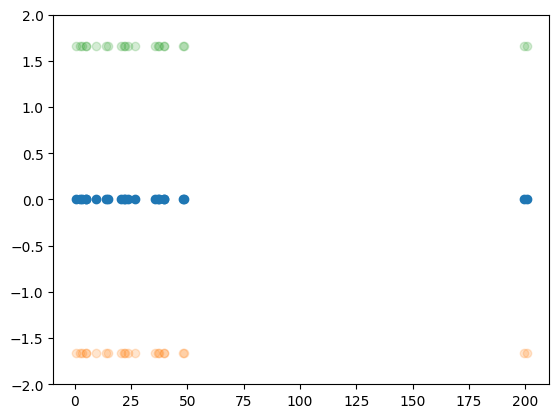

In [ ]:


mean_module_a = gpytorch.means.ConstantMean()
base_kernel_a = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
likelihood_a = gpytorch.likelihoods.GaussianLikelihood()




model_a = WeightedGPModel(x_gp, y_gp, mean_module_a, base_kernel_a, likelihood_a, w_gp)
model_a.set_train_data(inputs=x_gp, targets=y_gp, strict=True)

base_kernel_a.base_kernel.lengthscale = 25.0
likelihood_a.noise_covar.noise = 0.0001

posterior_a = likelihood_a(model_a(x_gp))
posterior_mean_a = posterior_a.mean
posterior_var_a = posterior_a.variance


plt.scatter(x_gp,posterior_mean_a.detach().numpy())
plt.scatter(x_gp.squeeze(),posterior_mean_a.detach().numpy()-2*torch.sqrt(posterior_var_a).detach().numpy(),alpha=0.2)
plt.scatter(x_gp.squeeze(),posterior_mean_a.detach().numpy()+2*torch.sqrt(posterior_var_a).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)
#var_l2_loss_estimator(model, test_x, Predictor, None, None)

model_a.covar_module(x_gp,x_gp).evaluate()

## **Question:** Is it sufficient to pass just the model and access the likelihood from model.likelihood instead of passing model and likelihood separately

## **Answer:**

Yes, that's correct. In many scenarios, especially when working within a framework like GPyTorch where the model and likelihood are closely integrated, it's sufficient to pass just the model object around in your code, as long as the likelihood has been properly attached to the model. Since you can access the likelihood via `model.likelihood`, there's no need to pass the likelihood separately in most cases. This approach keeps your code cleaner and reduces the risk of errors or inconsistencies that might arise from handling multiple objects separately.

### Benefits of Accessing Likelihood from the Model:

1. **Simplicity**: Reduces the complexity of function signatures and class constructors by requiring fewer arguments, making the code easier to read and maintain.

2. **Consistency**: Ensures that you are always using the correct likelihood associated with the model, avoiding potential bugs that could arise from mistakenly using a different likelihood object.

3. **Encapsulation**: Keeps the model and its associated likelihood together, which is a good practice in object-oriented design, encapsulating related functionalities within the same object or module.

### Example Usage:

When you define your model and likelihood in GPyTorch, and then integrate them, any function or method that requires access to either the model or the likelihood can do so through the model object itself. Here's an example to illustrate this:

```python
import gpytorch
import torch

class MyGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the model and likelihood
train_x = torch.randn(50)
train_y = torch.sin(train_x)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGPModel(train_x, train_y, likelihood)

# Example function that uses the model
def train(model, training_iterations=100):
    model.train()
    likelihood = model.likelihood  # Access likelihood from the model
    # Training code here...
    # You can use 'likelihood' as needed, without needing it passed separately

# Call the function with just the model
train(model)
```

In this setup, any further manipulation of the model or likelihood (such as adjusting hyperparameters, making predictions, or applying optimization steps) can be handled through the `model` object, utilizing `model.likelihood` to access the likelihood when necessary. This method of accessing the likelihood ensures that your code is modular and cohesive, maintaining a clear structure for managing the components of your Gaussian Process model.

## **Question:** Why do we do likelihood(model(x)) in gpytorch instead of model(x)

## **Answer:**
[Link 1](https://github.com/cornellius-gp/gpytorch/issues/1409)

[Link 2](https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html)

In [ ]:
class WeightedKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True

    def __init__(self, base_kernel: gpytorch.kernels.Kernel, weights: torch.Tensor):
        """
        Initializes the WeightedKernel with explicit weights.

        Args:
            base_kernel (gpytorch.kernels.Kernel): The base kernel.
            weights (Tensor): A tensor of precomputed weights.
        """
        super(WeightedKernel, self).__init__()
        self.base_kernel = base_kernel
        self.weights = weights

    def forward(self, x1, x2, diag=False, **params):
        weighted_covar = self.base_kernel(x1, x2, diag=diag, **params)
        if not diag:
            weight_matrix = self.weights.unsqueeze(-1) * self.weights.unsqueeze(-2)
            weighted_covar = weighted_covar * weight_matrix
        else:
            weighted_covar = weighted_covar * self.weights * self.weights
            #weighted_covar = weighted_covar
        return weighted_covar




class WeightedGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, mean_module, base_kernel, likelihood, weights):
        super(WeightedGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = WeightedKernel(base_kernel=base_kernel, weights=weights)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x, x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [ ]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3+13:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3+13:]


x_gp = torch.cat([x_train,x_pool_1], dim=0)
y_gp = torch.cat([y_train,y_pool_1], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.ones(x_pool_1.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1])

In [ ]:


class GaussianProcess(nn.Module):
    def __init__(self, kernel):
        super(GaussianProcess, self).__init__()
        self.kernel = kernel

    def forward(self, x_train, y_train, w_train, x_test, noise=1e-4):



        # Apply weights only to non-diagonal elements


        K = self.kernel(x_train, x_train) + noise * torch.eye(x_train.size(0))
        #print("K:",K)
        non_diag_mask = 1 - torch.eye(K.size(-2), K.size(-1))
        #print("non_diag_mask:",non_diag_mask)
        weight_matrix = w_train.unsqueeze(-1) * w_train.unsqueeze(-2)
        #print("weight_matrix:", weight_matrix)
        #print("weighted_K:", K*(non_diag_mask * weight_matrix + (1 - non_diag_mask)))
        weighted_K =  K * (non_diag_mask * weight_matrix + (1 - non_diag_mask))

        K_s = self.kernel(x_train, x_test)
        weighted_K_s = torch.diag(w_train)@K_s
        #print("K_s:",K_s)
        #print("weighted_K_s:",weighted_K_s)
        K_ss = self.kernel(x_test, x_test) + 1e-6 * torch.eye(x_test.size(0))
        #K_ss = self.kernel(x_test, x_test)
        #print("K_ss:", K_ss)
        weighted_K_inv = torch.inverse(weighted_K)
        #print("K_inv:", weighted_K_inv)
        mu = K_s.t()@(weighted_K_inv)@(y_train)
        cov = K_ss - ((weighted_K_s.t())@(weighted_K_inv)@(weighted_K_s))
        return mu.squeeze(), cov


(-2.0, 2.0)

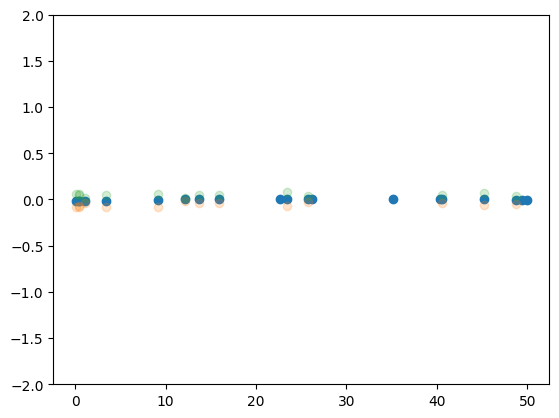

In [ ]:
x_train = x[:num_init_train_samples]
#x_pool_1 = x[num_init_train_samples+num_test_samples*3:]

y_train = y_new[:num_init_train_samples]
#y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:]

w_train = torch.ones(x_train.size(0), requires_grad = True)



kernel = RBFKernel(length_scale=25.0)
gp = GaussianProcess(kernel=kernel)

# Prediction
mu, cov = gp(x_train, y_train, w_train, x_train)

plt.scatter(x_train,mu.detach().numpy())
plt.scatter(x_train.squeeze(),mu.detach().numpy()-2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.scatter(x_train.squeeze(),mu.detach().numpy()+2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)

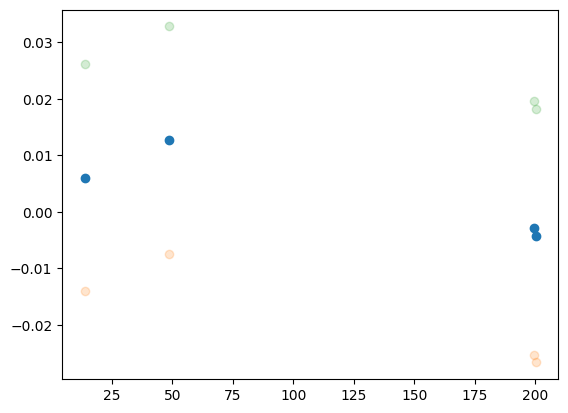

In [ ]:
x_train = x[:2]
x_pool_1 = x[num_init_train_samples+num_test_samples*3+13:]

y_train = y_new[:2]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3+13:]


x_gp = torch.cat([x_train,x_pool_1], dim=0)
y_gp = torch.cat([y_train,y_pool_1], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.ones(x_pool_1.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1])


kernel = RBFKernel(length_scale=25.0)
gp = GaussianProcess(kernel=kernel)

# Prediction
mu, cov = gp(x_gp, y_gp, w_gp, x_gp)

plt.scatter(x_gp,mu.detach().numpy())
plt.scatter(x_gp.squeeze(),mu.detach().numpy()-2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.scatter(x_gp.squeeze(),mu.detach().numpy()+2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)

In [ ]:


class GaussianProcessNormalCholesky(nn.Module):
    def __init__(self, kernel):
        super(GaussianProcessNormalCholesky, self).__init__()
        self.kernel = kernel

    def forward(self, x_train, y_train, w_train, x_test, noise=1e-4):


        K = self.kernel(x_train, x_train) + noise * torch.eye(x_train.size(0))
        K_s = self.kernel(x_train, x_test)
        K_ss = self.kernel(x_test, x_test) + 1e-8 * torch.eye(x_test.size(0))
        L = torch.linalg.cholesky(K)
        alpha = torch.cholesky_solve(y_train.unsqueeze(1), L)
        mu = K_s.t().matmul(alpha).squeeze(-1)

        v = torch.linalg.solve(L, K_s)
        cov = K_ss - v.t().matmul(v)
        return mu, cov


(-2.0, 2.0)

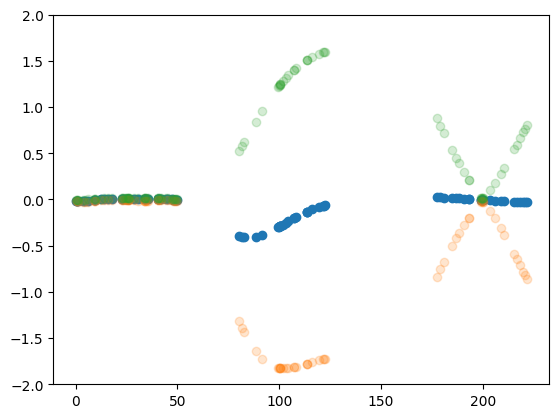

In [ ]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
x_pool_2 = x[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
y_pool_2 = y_new[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]


x_gp = torch.cat([x_train,x_pool_1,x_pool_2], dim=0)
y_gp = torch.cat([y_train,y_pool_1,y_pool_2], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_pool_2 = torch.ones(x_pool_2.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1,w_pool_2])



kernel = RBFKernel(length_scale=25.0)
gp = GaussianProcessNormalCholesky(kernel=kernel)

# Prediction
mu1, cov1 = gp(x_gp, y_gp, w_gp, x)

plt.scatter(x,mu.detach().numpy())
plt.scatter(x.squeeze(),mu.detach().numpy()-2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),mu.detach().numpy()+2*torch.sqrt(torch.diag(cov)).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)

(-2.0, 2.0)

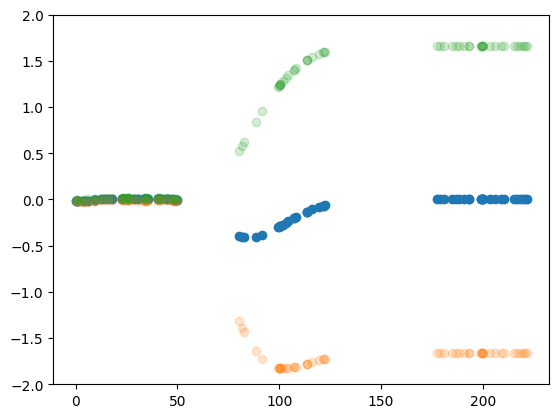

In [ ]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
x_pool_2 = x[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:num_init_train_samples+num_test_samples*3+num_pool_samples*3-2]
y_pool_2 = y_new[num_init_train_samples+num_test_samples*3+num_pool_samples*3-2:]


x_gp = torch.cat([x_train], dim=0)
y_gp = torch.cat([y_train], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_pool_2 = torch.ones(x_pool_2.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1,w_pool_2])



kernel = RBFKernel(length_scale=25.0)
gp = GaussianProcessNormalCholesky(kernel=kernel)

# Prediction
mu1, cov1 = gp(x_gp, y_gp, w_gp, x)

plt.scatter(x,mu1.detach().numpy())
plt.scatter(x.squeeze(),mu1.detach().numpy()-2*torch.sqrt(torch.diag(cov1)).detach().numpy(),alpha=0.2)
plt.scatter(x.squeeze(),mu1.detach().numpy()+2*torch.sqrt(torch.diag(cov1)).detach().numpy(),alpha=0.2)
plt.ylim(-2, 2)

In [ ]:
print(mu1)
print(mu2)
print(torch.diag(cov1))
print(torch.diag(cov2))

tensor([-3.9116e-03,  3.3259e-03, -6.4555e-03,  2.1836e-04,  6.4327e-03,
         7.4193e-03, -8.6703e-03,  3.5091e-03, -1.1096e-02,  4.2413e-03,
         4.6255e-03, -6.5717e-03, -1.4896e-02,  3.3790e-03, -1.1974e-02,
        -1.1905e-02,  3.1856e-04, -1.3246e-02,  6.8094e-03,  3.3816e-03,
         8.2112e-03, -1.2501e-02,  7.2716e-03, -1.4219e-02,  4.1380e-03,
         1.9909e-03,  3.4597e-04,  3.6800e-04, -9.9041e-05, -1.1470e-04,
        -2.3454e-03, -5.9284e-03, -5.0883e-03,  4.0489e-03, -8.9426e-05,
        -1.5067e-03,  4.6934e-04, -5.8081e-05,  3.4035e-03,  3.8798e-03,
        -1.3191e-01, -3.9401e-01, -2.0355e-01, -4.0557e-01, -2.5365e-01,
        -1.3222e-01, -3.8231e-01, -6.8239e-02, -6.4774e-02, -2.0402e-01,
        -4.0206e-01, -2.8789e-01, -8.3230e-02, -2.3764e-01, -6.7689e-02,
        -2.7167e-01, -4.0158e-01, -1.0802e-01, -1.9112e-01, -1.3108e-01,
        -4.8204e-06, -1.0923e-05, -2.9349e-09, -2.2291e-08, -1.9594e-09,
        -1.5890e-05, -2.3439e-06, -2.1761e-07, -3.2

(-2.0, 2.0)

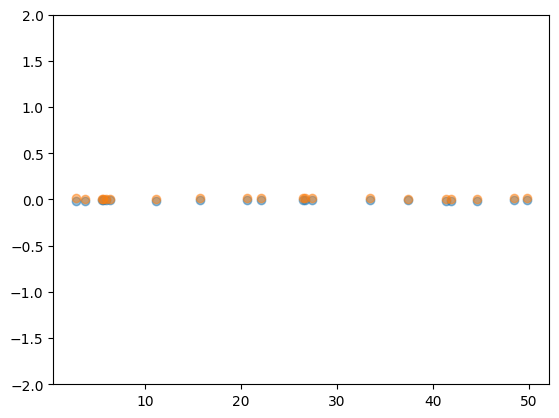

In [58]:
x_train = x[:num_init_train_samples]
x_pool_1 = x[num_init_train_samples+num_test_samples*3:]

y_train = y_new[:num_init_train_samples]
y_pool_1 = y_new[num_init_train_samples+num_test_samples*3:]


x_gp = torch.cat([x_train,x_pool_1], dim=0)
y_gp = torch.cat([y_train,y_pool_1], dim=0)

w_train = torch.ones(x_train.size(0), requires_grad = True)
w_pool_1 = torch.zeros(x_pool_1.size(0), requires_grad = True)
w_gp = torch.cat([w_train,w_pool_1])


kernel = RBFKernel(length_scale=25.0, output_scale = 0.6931471824645996)
gp = GaussianProcessCholesky(kernel=kernel)

# Prediction
mu1, cov1 = gp(x_gp, y_gp, w_gp, x_train)

#plt.scatter(x_train,mu1.detach().numpy())
plt.scatter(x_train.squeeze(),mu1.detach().numpy()-2*torch.sqrt(torch.diag(cov1)).detach().numpy(),alpha=0.5)
plt.scatter(x_train.squeeze(),mu1.detach().numpy()+2*torch.sqrt(torch.diag(cov1)).detach().numpy(),alpha=0.5)
plt.ylim(-2, 2)




In [ ]:
print(mu)
print(mu1)
print(torch.diag(cov))
print(torch.diag(cov))

tensor([-0.0039,  0.0033, -0.0064,  0.0002,  0.0064,  0.0074, -0.0087,  0.0035,
        -0.0111,  0.0042,  0.0046, -0.0066, -0.0149,  0.0034, -0.0120, -0.0119,
         0.0003, -0.0133,  0.0068,  0.0034], grad_fn=<SqueezeBackward0>)
tensor([0.0148, 0.0346, 0.0218, 0.0313, 0.0388, 0.0417, 0.0087, 0.0305, 0.0099,
        0.0386, 0.0390, 0.0114, 0.0089, 0.0306, 0.0094, 0.0094, 0.0307, 0.0086,
        0.0412, 0.0260], grad_fn=<SqueezeBackward0>)
tensor([ 5.1272e-04,  4.9108e-04,  1.2459e-03, -1.3214e-04,  4.3803e-04,
        -1.9884e-04, -3.8749e-04,  4.1151e-04,  1.3939e-03, -1.4919e-04,
         3.4076e-04, -9.2465e-04,  1.1296e-03, -8.0264e-04,  8.7637e-04,
         1.0994e-03,  8.6308e-05,  1.9008e-04,  1.2966e-03,  1.1484e-03],
       grad_fn=<DiagonalBackward0_copy>)
tensor([ 5.1272e-04,  4.9108e-04,  1.2459e-03, -1.3214e-04,  4.3803e-04,
        -1.9884e-04, -3.8749e-04,  4.1151e-04,  1.3939e-03, -1.4919e-04,
         3.4076e-04, -9.2465e-04,  1.1296e-03, -8.0264e-04,  8.7637e-04,
 